<a href="https://colab.research.google.com/github/papercup-open-source/tutorials/blob/master/intro_bnn/Bayesian_neural_networks_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Disclaimer

Much of this notebook is based on a lecture on neural networks by the late David Mackay, which can be found [here](https://www.youtube.com/watch?v=Z1pcTxvCOgw). The data and python examples below are adapted from the lecture and the original Octave code on his website.

# Set up

Suppose you want to classify some data points, such as the ones shown in the diagram below. Let $\mathbf{x}$ be the location of the data points (and the inputs to our neural net), $t$ be the class of these points, and let's use the letter $D$ to represent the entire dataset of $N$ points.

$$
\begin{aligned}
  D &= \{\mathbf{x}_n, t_n\}_{n=1}^N \\
t_n &\in \{0, 1\}
\end{aligned}
$$

In [0]:
%matplotlib inline

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import jax
import jax.numpy as np
from jax import random
from jax import jit, grad
from jax import vmap, partial

from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from google.colab import files

key = random.PRNGKey(0)

In [0]:
key, subkey = random.split(key)

x_range = np.linspace(0, 10, 100)
y_range = np.linspace(0, 10, 100)
Zd = np.stack((
    np.expand_dims(x_range, axis=1).repeat(100, axis=1),
    np.expand_dims(y_range, axis=0).repeat(100, axis=0),
    np.ones((100, 100)),
), axis=2)

In [0]:
def plot_fns_and_weights(fns, weights, idx):
  x_range = np.linspace(0, 10, 100)
  y_range = np.linspace(0, 10, 100)
  fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(12, 6))

  # Plot weight values on x1 and x2
  ax2.set(xlim=(-1, 5), ylim=(-1, 5))
  ax2.scatter(weights[:, 0], weights[:, 1])
  ax2.set_xlabel('$w_1$')
  ax2.set_ylabel('$w_2$')

  # Plot the weights values as training continues
  ax3.plot(weights[:, 0])
  ax3.plot(weights[:, 1])
  ax3.plot(weights[:, 2])
  ax3.set_xlabel('Step')
  ax3.set_ylabel('$|w_i|$')

  # Animation
  fig, ax = plt.subplots(figsize=(6, 6))
  plt.close()
  ax.set(xlim=(0, 10), ylim=(0, 10))

  ax.scatter(D1[:, 0], D1[:, 1])
  ax.scatter(D2[:, 0], D2[:, 1])
  ax.set_xlabel('$x_1$')
  ax.set_ylabel('$x_2$')
  ax.set_title("Step: {}".format(0))
  cont = ax.contour(x_range, y_range, fns[0], origin='lower', cmap=cm.viridis, vmin=0, vmax=1)

  def animate(i):
      ax.cla()
      ax.scatter(D1[:, 0], D1[:, 1])
      ax.scatter(D2[:, 0], D2[:, 1])
      ax.set_xlabel('$x_1$')
      ax.set_ylabel('$x_2$')
      ax.set_title("Step: {}".format(idx[i]))
      ax.contour(x_range, y_range, fns[i], vmin=0, vmax=1)

  anim = FuncAnimation(fig, animate, interval=200, frames=len(idx))
  return anim

[(0, 10), (0, 10)]

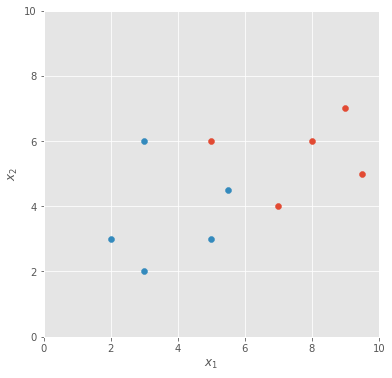

In [0]:
D1 = np.array([
    (7, 4),
    (5, 6),
    (8, 6),
    (9.5, 5),
    (9, 7),
])
D2 = np.array([
    (2, 3),
    (3, 2),
    (3, 6),
    (5.5, 4.5),
    (5, 3),
])

D_tmp = np.concatenate((D1, D2), axis=0)
D = np.concatenate((D_tmp, np.ones((10, 1))), axis=1)
t = np.concatenate((np.array([1.]*5), np.array([0.]*5)))

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(D1[:, 0], D1[:, 1])
ax.scatter(D2[:, 0], D2[:, 1])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set(xlim=(0, 10), ylim=(0, 10))

In [0]:
@jit
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

@jit
def bce_loss(W, D, t):
    a = np.dot(D, W)
    y = sigmoid(a)
    error = (- t * np.log(y) - (1 - t) * np.log(1 - y)).sum()

    return error

@jit
def regularization_loss(W):
   return 0.5 * (W.dot(W)).sum()

# Neural nets - Prior Experience

Let's use a simple single-layer perceptron as our classifier, with three weights: $w_1$, $w_2$ and $w_3$ for $x_1$, $x_2$ and the bias, respectively, and a sigmoid activation function $\sigma()$ to obtain an estimate of the class probability. We make the assumption here that the neural net model we use is powerful enough to generate the dataset.

$$
\begin{aligned}
P(t_{N+1} = 1 | \mathbf{x}_{N+1}, \mathbf{w}, D) &= f_{\text{nn}}(\mathbf{x}_{N+1}; \mathbf{w}) \\
                                                 &= \sigma(\mathbf{x}^T \mathbf{w})
\end{aligned}
$$

### Maximum Likelihood training

In maximum likelihood training, we adjust the weight parameters $\mathbf{w}$ of our neural net classifier to maximise the likelihood of the data given the parameters, and we use it to make predictions on new data points. So let's by defining our loss function $\ell(\mathbf{w})$ to be $G(\mathbf{w})$ - the negative log-likelihood, which in this case is the binary cross entropy:

$$
\begin{aligned}
\ell(\mathbf{w}) = G(\mathbf{w}) &= - \log( P(D|\mathbf{w}) ) \\
                                 &= \sum_{n=1}^N - t_n \log(y_n) - (1 -t_n)\log(1-y_n) \\
           \text{s.t.} \quad y_n &= f_{\text{nn}}(\mathbf{x}_n; \mathbf{w})
\end{aligned}
$$

If we run batch gradient descent for some time, the classifier function settles into a state where the decision boundary is sharply in the middle between the two classes of data points.

In [0]:
eta = 0.02
W = random.normal(key, (3,)) * 0.25
idx = []
fns = []
weights = []

@jit
def step(W, D, t, eta=0.02):
  dW = grad(bce_loss)(W, D, t)
  W = W - eta * dW

  return W

for k in range(20001):
  # Calculate and save for contour lines
  if (k % 1000 == 0) or (k <= 1000 and k % 100 == 0):
    idx.append(k)
    a = np.dot(Zd, W)
    y = sigmoid(a)
    fns.append(y)

  W = step(W, D, t, eta=eta)

  weights.append(W)

fns = np.array(fns)
weights = np.array(weights)

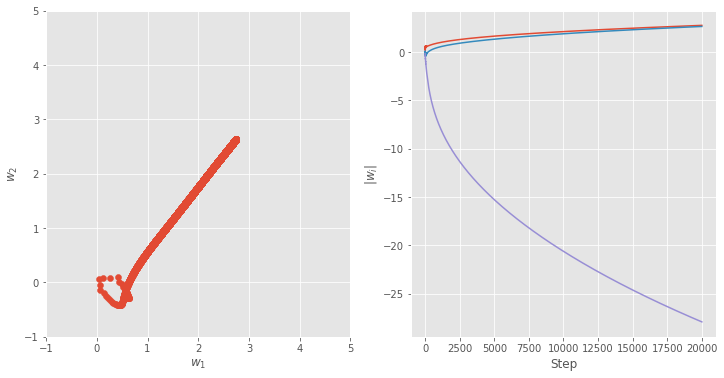

In [0]:
anim = plot_fns_and_weights(fns, weights, idx)
HTML(anim.to_html5_video())

### Add in a regulariser

Now, as David says in his lecture, you may well find the harshness of this classifier a little concerning, so we can introduce an additional penalty to our loss called "weight decay" or a "regulariser", where we penalise the entire weight vector against having a large $L_2$-norm. If we call this regularisation term $E(\mathbf{w})$, controlled by a hyper-parameter $\alpha$, it means our new loss function becomes:

$$
\begin{aligned}
                                  E(\mathbf{w}) &= \frac{1}{2} \|\mathbf{w}\|_2^2 \\
                 \text{let} \quad M(\mathbf{w}) &= G(\mathbf{w}) + \alpha E(\mathbf{w}) \\
\text{s.t.} \quad \ell_{\text{new}}(\mathbf{w}) &= M(\mathbf{w}) \\
                                                &= \sum_n -t_n \log(y_n) - (1 -t_n)\log(1-y_n) + \alpha \, \frac{1}{2}\|\mathbf{w}\|_2^2
\end{aligned}
$$

With this new loss function, we're able to train our model with more regularisation that is controlled by a hyper-parameter $\alpha$, where larger values of $\alpha$ give us smoother decision boundaries after training.

In [0]:
eta = 0.02
alpha = 0.01
W = random.normal(key, (3,)) * 0.25
idx = []
fns = []
weights = []

@jit
def loss(W, D, t, alpha):
  return bce_loss(W, D, t) + alpha * regularization_loss(W)

@jit
def step(W, D, t, eta=0.02, alpha=0.01):
  dW = grad(loss)(W, D, t, alpha)
  W = W - eta * dW

  return W

for k in range(10001):
  # Calculate and save for contour lines
  if (k % 1000 == 0) or (k <= 1000 and k % 100 == 0):
    idx.append(k)
    a = np.dot(Zd, W)
    y = sigmoid(a)
    fns.append(y)

  W = step(W, D, t, eta=eta, alpha=alpha)

  weights.append(W)

fns = np.array(fns)
weights = np.array(weights)

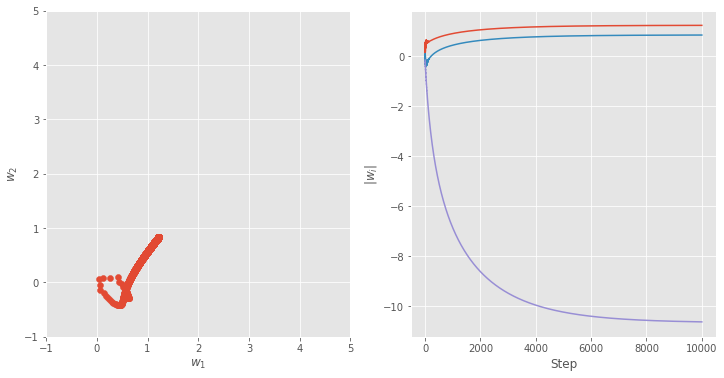

In [0]:
anim = plot_fns_and_weights(fns, weights, idx)
HTML(anim.to_html5_video())

# Bayesian inference over weights

### Langevin Monte Carlo method - *MCMC Hammer*

With a Monte Carlo method, we aim to draw $K$ credible samples from the posterior distribution, then estimating the marginal likelihood as the average of the outputs generated by the function using the sampled parameters.

$$
\begin{aligned}
P(y_{N+1} = 1 | \mathbf{x}_{N+1}, D) &\approx \frac{1}{K} \sum_{k=1}^{K} P(y_{N+1} = 1 | \mathbf{x}_{N+1}, \mathbf{w}_k, D) \\
                                   &= \frac{1}{K} \sum_{k=1}^{K} f_{\text{nn}}(\mathbf{x} ; \mathbf{w}_k)
\end{aligned}
$$

The first example here is a Markov Chain Monte Carlo approach using Langevin sampling, where for each step we perform batch gradient descent and add a bit of noise to it. The Langevin Monte Carlo method is a special case of Hamiltonian Monte Carlo. An acceptance rule (Metropolis Hastings) is used to decide whether to accept or reject each proposed step we take, and we take samples once every few steps to reduce correlation between the drawn samples.

So now we've obtained $K$ samples of the weight vector from the Monte Carlo method and we can average across all the different predictions made using each of them. Below we show each of the 30 sampled classifiers (produced by the sampled weights) we obtained from our Langevin Monte Carlo method - some of them similar to the trained classifier we had before, some of them less so.

In [0]:
@jit
def loss(W, D, t, alpha):
  return bce_loss(W, D, t) + alpha * regularization_loss(W)

@jit
def step(W, dW, M, k1):
  p = random.normal(k1, (3,))
  H = (p ** 2).sum() / 2 + M
  
  # For Hamiltonian Monte Carlo, run the following 4 lines for tau iterations, 
  # tau > 1
  p = p - epsilon / 2 * dW
  new_W = W + epsilon * p
  new_dW = grad(loss)(new_W, D, t, alpha=alpha)
  p = p - epsilon / 2 * new_dW

  new_M = loss(new_W, D, t, alpha=alpha)
  new_H = (p ** 2).sum() / 2 + new_M

  dH = new_H - H

  return dH, new_W, new_dW, new_M, k1

eta = 0.02
epsilon = np.sqrt(2 * eta)
alpha = 0.01
W = random.normal(key, (3,)) * 0.25
idx = []
fns = []
weights = []
k0 = 2000

accepts = 0
M = loss(W, D, t, alpha=alpha)
dW = - grad(loss)(W, D, t, alpha=alpha)

k1, k2 = random.split(key)

for k in range(10001):
  k1, k2 = random.split(k1)
  dH, new_W, new_dW, new_M, k1 = step(W, dW, M, k1)

  if (dH < 0) or (random.uniform(k2) < np.exp(-dH)):
    accepts += 1
    W = new_W
    M = new_M
    dW = new_dW

  if (k > k0 and k % 100 == 0):
    weights.append(W)
    a = np.dot(Zd, W)
    y = sigmoid(a)
    fns.append(y)
    idx.append(k)

fns = np.array(fns)
weights = np.array(weights)

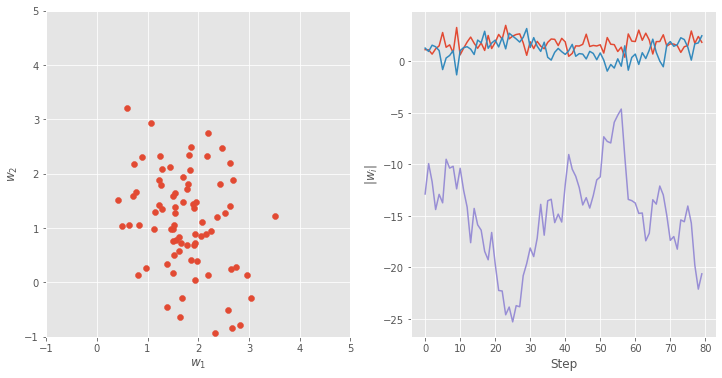

In [0]:
anim = plot_fns_and_weights(fns, weights, idx)
HTML(anim.to_html5_video())

Averaging across all of these sampled functions, we obtain a marginal likelihood classifier that looks very different from before:

Text(0, 0.5, '$x_2$')

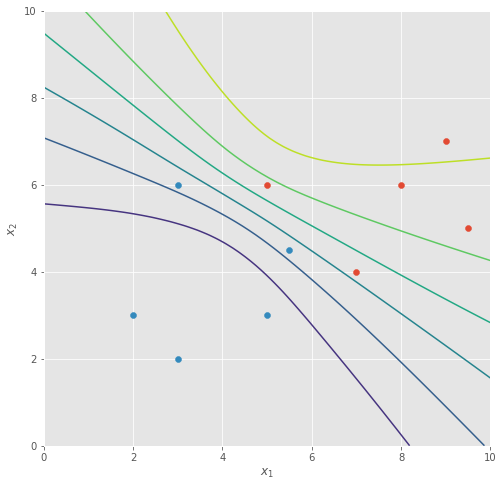

In [0]:
Z = fns.mean(axis=0)
plt.figure(figsize=(8, 8))
_ = plt.contour(x_range, y_range, Z, origin='lower',
                cmap=cm.viridis, vmin=0, vmax=1)
plt.scatter(D1[:, 0], D1[:, 1])
plt.scatter(D2[:, 0], D2[:, 1])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

Another question one might ask is: since each weight vector corresponds to a function represented by the output of the neural net, doesn't that mean there's a whole distribution of functions as well?

Text(0, 0.5, '$x_2$')

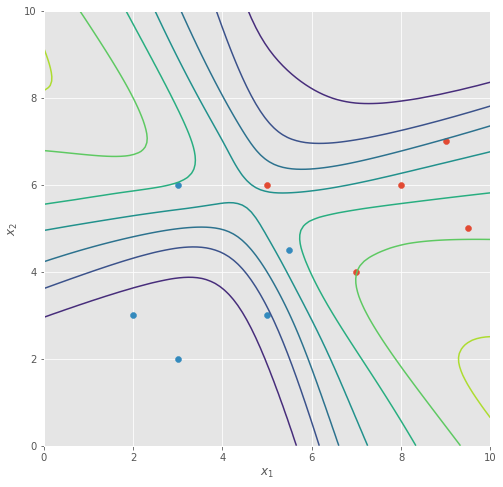

In [0]:
Z = fns.std(axis=0)
plt.figure(figsize=(8, 8))
_ = plt.contour(x_range, y_range, Z, origin='lower',
                cmap=cm.viridis)
plt.scatter(D1[:, 0], D1[:, 1])
plt.scatter(D2[:, 0], D2[:, 1])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

### Laplace's method - *Tame your expectations*

The implementation in this subsection is based from Section 41.5 from [David's textbook](http://www.inference.org.uk/mackay/itprnn/book.html) (pg. 501).

With Laplace's method, we model the posterior distribution as a multivariate Gaussian distribution with its mean at the MAP estimate $\mathbf{w}_{\text{MAP}}$ (which is the $\mathbf{w}$ we found using the regularised optimisation) and its covariance matrix calculated as the inverse of the Hessian $H$ at $\mathbf{w}_{\text{MAP}}$.

$$
\begin{aligned}
          P(\mathbf{w} | D) &\approx Q(\mathbf{w} | \theta) \\
     Q(\mathbf{w} | \theta) &= \text{Normal}(\mathbf{w}_{\text{MAP}}, H^{-1}) \\
\text{where} \quad \theta &= \{ \mathbf{w}_{\text{MAP}}, H^{-1} \}
\end{aligned}
$$

In [0]:
eta = 0.02
alpha = 0.01
W = random.normal(key, (3,)) * 0.25
idx = []
fns = []
weights = []


@jit
def loss(W, D, t, alpha):
  return bce_loss(W, D, t) + alpha * regularization_loss(W)


@jit
def step(W, D, t, eta=0.02, alpha=0.01):
  dW = grad(loss)(W, D, t, alpha=alpha)
  W = W - eta * dW

  return W


for k in range(10001):
  W = step(W, D, t, eta=eta, alpha=alpha)

W_MAP = W

In [0]:
from jax import jacfwd, jacrev  # forward and reverse-mode

def hessian(fun):
  return jit(jacfwd(jacrev(fun)))  # jit!

hess = hessian(loss)(W_MAP, D, t, 0.01)
Sigma = np.linalg.inv(hess)

In [0]:
print(Sigma)

[[ 0.6003374   0.09462781 -3.6178472 ]
 [ 0.0946256   0.7918672  -4.2730017 ]
 [-3.617836   -4.2730136  40.54968   ]]


The marginal likelihood under $Q$ can be approximated in closed form using an approximation of the integral of a sigmoid multiplied with a Gaussian. Note that this is now an approximation of an approximation.

$$
\begin{aligned}
P(y_{N+1}|\mathbf{x}_{N+1}, D) &\approx \int P(y_{N+1}|\mathbf{x}_{N+1}, \mathbf{w}, D) Q(\mathbf{w}| \theta) \, d\mathbf{w} \\
                             &\approx \sigma(\kappa(s) \mathbf{w}_\text{MAP}^T \mathbf{x}_{N+1}) \\
\text{where} \quad \kappa(s) &= \frac{1}{\sqrt{1+\pi s^2 / 8}} \\
                         s^2 &= \mathbf{x}_{N+1}^T H^{-1} \mathbf{x}_{N+1}
\end{aligned}
$$

Using the marginal likelihood approximation, we obtain the classifier below, which is similar to the Monte Carlo method we showed before.

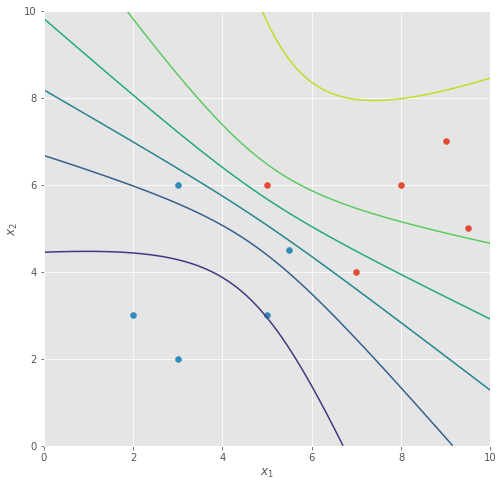

In [0]:
# Approximation method for inference
kappa = (Zd.dot(Sigma) * Zd).sum(2)
kappa = 1 / (1 + np.pi * kappa / 8) ** 0.5

a = np.dot(Zd, W_MAP) * kappa
Z = sigmoid(a)


plt.figure(figsize=(8, 8))
_ = plt.contour(x_range, y_range, Z, origin='lower',
                cmap=cm.viridis, vmin=0, vmax=1)
plt.scatter(D1[:, 0], D1[:, 1])
plt.scatter(D2[:, 0], D2[:, 1])
_ = plt.xlabel('$x_1$')
_ = plt.ylabel('$x_2$')

In general we're not so lucky to have a closed-form solution or approximation to our approximate marginal likelihood. Nonetheless, since we have an explicit model of $Q$, we can also sample from $Q$ and obtain individual sampled functions like before from the LMC method:

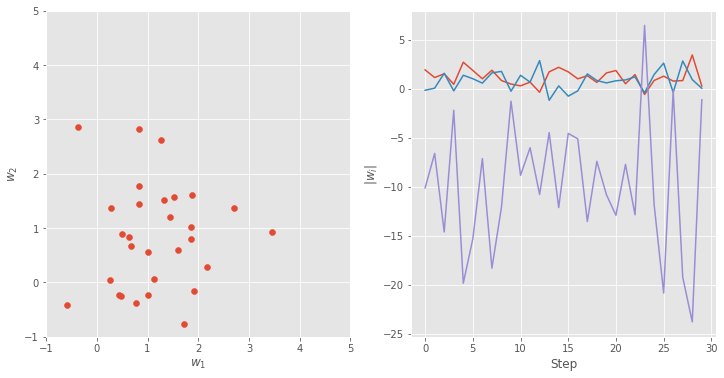

In [0]:
# Monte Carlo method for inference
K_inference = 30
sigma = np.linalg.cholesky(Sigma)

k1, k2 = random.split(key)
eps = random.normal(k1, (K_inference, 3))

W = W_MAP + vmap(sigma.dot)(eps)

partial_func = partial(lambda e: np.dot(Zd, e))

a = vmap(partial_func)(W)
fns = sigmoid(a)

anim = plot_fns_and_weights(fns, W, range(len(fns)))
HTML(anim.to_html5_video())

And in the function space, if we plot out the mean and standard deviations, we obtain diagrams that look similar to what we obtained from the closed-form approximations.

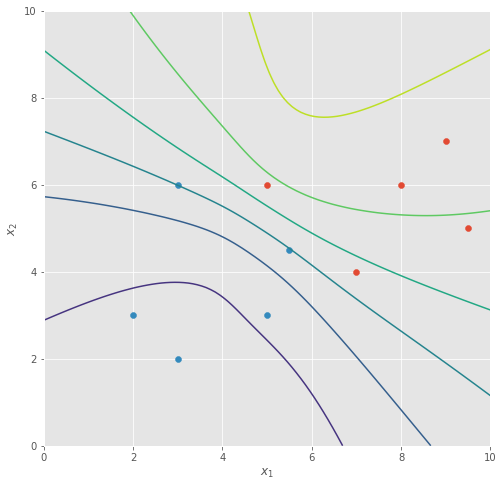

In [0]:
Z = fns.mean(0)
plt.figure(figsize=(8, 8))
_ = plt.contour(x_range, y_range, Z, origin='lower',
                cmap=cm.viridis, vmin=0, vmax=1)
plt.scatter(D1[:, 0], D1[:, 1])
plt.scatter(D2[:, 0], D2[:, 1])
_ = plt.xlabel('$x_1$')
_ = plt.ylabel('$x_2$')

Text(0, 0.5, '$x_2$')

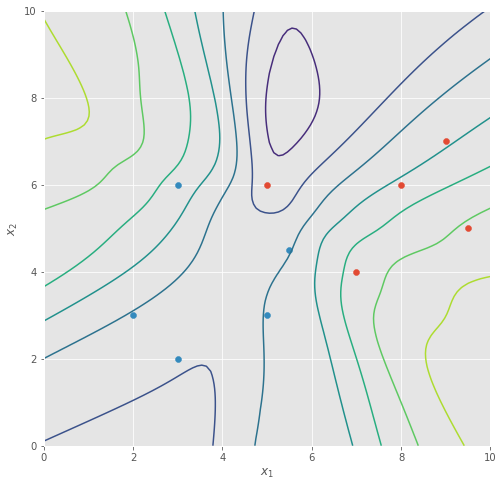

In [0]:
Z = fns.std(axis=0)
plt.figure(figsize=(8, 8))
_ = plt.contour(x_range, y_range, Z, origin='lower',
                cmap=cm.viridis)
plt.scatter(D1[:, 0], D1[:, 1])
plt.scatter(D2[:, 0], D2[:, 1])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

### Variational Free Energy method - *VI-ing for attention*

In this final example for the classifier, we use a variational inference method to, again, approximate the posterior distribution. The difference here is that the approximate distribution is reached by minimising the distance between the proposal distribution with the true posterior distribution according to some distance measure. A common distance metric is the forward KL-divergence, which is an asymmetric measure (hence "forward" vs "backward"). Note that this is related to, but not the same as, Variational Autoencoders, though one could argue that variational inference is popular nowadays because of VAEs.

$$
\begin{aligned}
\text{KL}(Q \, || \, P) = \mathbb{E}_{Q} \bigg[ \log\bigg( \frac{Q}{P} \bigg) \bigg]
\end{aligned}
$$

In our case, we can derive the following:

$$
\begin{aligned}
\text{KL}(Q(\mathbf{w} | \theta) \, || \, P(\mathbf{w} | D)) &= \int Q(\mathbf{w} | \theta) \log \bigg( \frac{Q(\mathbf{w} | \theta)}{P(\mathbf{w} | D)} \bigg) d\mathbf{w} \\
&= \int Q(\mathbf{w} | \theta) \log \bigg( \frac{Q(\mathbf{w} | \theta)}{ e^{M(\mathbf{w})} } \bigg) d\mathbf{w} + \log(Z) \\
&= \underbrace{ \mathbb{E}_{Q(\mathbf{w} | \theta)} [\log(Q(\mathbf{w} | \theta))] - \int Q(\mathbf{w} | \theta) M(\mathbf{w}) \, d\mathbf{w} }_\text{Variational Free Energy/Evidence Lower Bound} + \log(Z)
\end{aligned}
$$

such that the first two term together (and its variants) are called the Variational Free Energy (VFE), comprising of the entropy of $Q$ in addition to the negative expected total energy under $Q$. $\theta$ again represents the parameters of the multivariate Gaussian distribution. The Variational Free Energy is also known as the Evidence Lower Bound (ELBO), as it gives us a bound on $\log(Z)$ and therefore $P(D)$, since a KL divergence is always non-negative.

Alternatively the VFE/ELBO can be rearranged and expressed as:

$$
\text{ELBO} = \text{KL}(Q(\mathbf{w} | \theta) \, || \, P(\mathbf{w})) - \mathbb{E}_{Q(\mathbf{w} | \theta)} [ \log(P(D | \mathbf{w})) ]
$$

i.e. the KL-divergence between the proposed distribution $Q$ and the prior $P(\mathbf{w})$, and the expected negative log-likelihood under $Q$.

The bad news is that with a Gaussian distrbution, the second term (the expectation) in the VFE/ELBO in both the first and second form is generally intractable, so we resort to estimation methods once again. One such "modern" method - Bayes by Backprop - is described in [Blundell et al (2015)](https://arxiv.org/pdf/1505.05424.pdf), making use of the reparametrisation trick introduced in [Kingma and Welling, 2014](https://arxiv.org/pdf/1312.6114.pdf) and [Rezende et al, 2014](https://arxiv.org/pdf/1401.4082.pdf). It is a Monte Carlo based method that iteratively updates the $Q$ distribution parameters $\theta$ (this is different from "model training", despite the practical similarities).

Bayes by Backprop was implemented by modelling the posterior distribution as a multivariate Gaussian with a diagonal covariance matrix. If we approximate the marginal likelihood by drawing samples from the $Q$ distribution and plotting the function space mean and standard deviations using these samples, we get the results below.


In [0]:
eta = 0.02
alpha = 0.01
K = 10 # Number of Monte Carlo samples

k1, k2 = random.split(key)
theta = random.normal(k1, (6,))
idx = []
fns = []
weights = []


@jit
def map_loss(W, D, t, alpha):
  return bce_loss(W, D, t) + alpha * regularization_loss(W)


@jit
def vi_loss(theta, eps, D, t, alpha):
  mu = theta[:3]
  log_sigma = theta[3:]
  sigma = np.exp(log_sigma)
  W = mu + eps * sigma
  errors = map_loss(W, D, t, alpha)

  return errors

@jit
def KL_loss(theta):
  log_sigma = theta[3:]
  return - (log_sigma).sum()

@jit
def step(theta, D, t, k1, eta=0.02, alpha=0.01):
  eps = random.normal(k1, (K, 3))

  partial_loss_func = partial(lambda e: grad(vi_loss)(theta, e, D=D, t=t, alpha=alpha))

  dtheta = np.nanmean(vmap(partial_loss_func)(eps), 0)

  d_KL_theta = grad(KL_loss)(theta)

  theta = theta - eta * (dtheta + d_KL_theta)

  return theta

for k in range(10001):
  k1, k2 = random.split(k1)

  theta = step(theta, D, t, k1, eta=eta, alpha=alpha)

In [0]:
print(theta)

[  1.7252898    0.95954394 -14.1275215   -1.3678851   -1.3724306
   0.29003334]


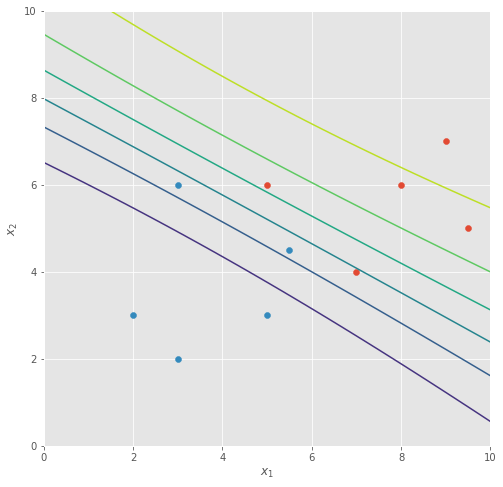

In [0]:
# Approximation method
mu = theta[:3]
log_sigma = theta[3:]
Sigma = np.diag(np.exp(log_sigma * 2))

kappa = (Zd.dot(Sigma) * Zd).sum(2)
kappa = 1 / (1 + np.pi * kappa / 8) ** 0.5

a = np.dot(Zd, mu) * kappa
Z = sigmoid(a)

plt.figure(figsize=(8, 8))
_ = plt.contour(x_range, y_range, Z, origin='lower',
                cmap=cm.viridis, vmin=0, vmax=1)
plt.scatter(D1[:, 0], D1[:, 1])
plt.scatter(D2[:, 0], D2[:, 1])
_ = plt.xlabel('$x_1$')
_ = plt.ylabel('$x_2$')

And you might well say "oh dear, this isn't what we expected". The standard deviation diagram suggests that the classifier is still "curved", but not nearly as much as we saw in the Langevin method or Laplace's method. What we can also do is compare the distribution we've produced using the variational method against what we obtained from Laplace's method.

If we print out the covariance matrix, we can see where the problem might be coming from. The covariance matrix from Laplace's method captures significant off-diagonal covariance values between the weights, while this information is lost when we assume independence between the each of the values in the weight vectors.

In [0]:
  print(Sigma)

[[0.06484404 0.         0.        ]
 [0.         0.06425722 0.        ]
 [0.         0.         1.7861575 ]]


This means that when we apply the independence assumption to the dimensions in our weights, we should do so carefully and consider whether it's a good approximation to make or not.

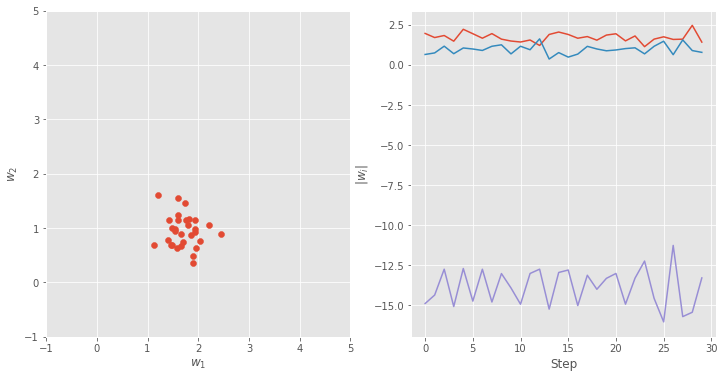

In [0]:
# Monte Carlo method for inference
K_inference = 30
sigma = np.exp(log_sigma)

k1, k2 = random.split(key)
eps = random.normal(k1, (K_inference, 3))

partial_func = partial(lambda e: np.multiply(sigma, e))
W = mu + vmap(partial_func)(eps)

partial_func = partial(lambda e: np.dot(Zd, e))

a = vmap(partial_func)(W)
fns = sigmoid(a)

anim = plot_fns_and_weights(fns, W, range(len(fns)))
HTML(anim.to_html5_video())

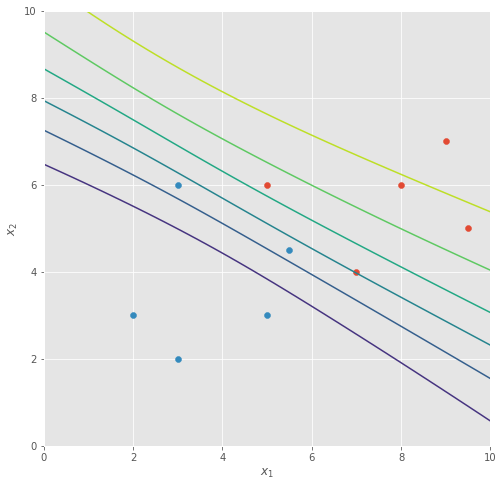

In [0]:
Z = fns.mean(0)
plt.figure(figsize=(8, 8))
_ = plt.contour(x_range, y_range, Z, origin='lower',
                cmap=cm.viridis, vmin=0, vmax=1)
plt.scatter(D1[:, 0], D1[:, 1])
plt.scatter(D2[:, 0], D2[:, 1])
_ = plt.xlabel('$x_1$')
_ = plt.ylabel('$x_2$')

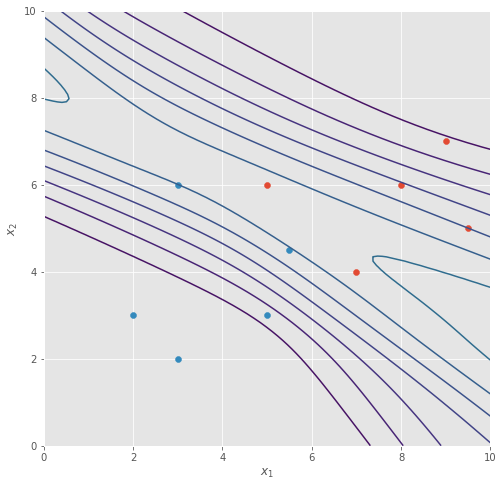

In [0]:
Z_std = fns.std(axis=0)
plt.figure(figsize=(8, 8))
_ = plt.contour(x_range, y_range, Z_std, origin='lower',
                cmap=cm.viridis, vmin=0, vmax=1)
plt.scatter(D1[:, 0], D1[:, 1])
plt.scatter(D2[:, 0], D2[:, 1])
_ = plt.xlabel('$x_1$')
_ = plt.ylabel('$x_2$')